# Chapter 8: Two-Point Boundary Value Problems

Solve $y'' = f(x, y, y'), \quad y(a) = \alpha ; \quad y(b) = \beta$

## Introduction

Since the auxiliary conditions are not given at the same point ($a \neq b$), we cannot use the iterative techniques seen in the previous Chapter.

Solutions:
1. Guess the missing values, adjust guesses based on observed error (*shooting* method)
2. Approximate equations with *finite differences*.

Both methods lead to systems of non-linear equations. They need good starting values to converge.

## Shooting Method

### Second-Order Differential Equation

#### Formulation as a root-finding problem

We consider the following problem with $a \neq b$:
$$
y'' = f(x, y, y'), \quad y(a) = \alpha ; \quad y(b) = \beta
$$

We will find $u$ such that the problem can be converted to an initial value problem in the following form:
$$
y'' = f(x, y, y'), \quad y(a) = \alpha ; \quad y'(a) = u \quad \textbf{(2)}
$$

We have:
$$
y(b) = \theta(u)
$$

And we want to find $u$ such that:
$$
y(b) = \beta
$$
That is:
$$
r(u) = \theta(u) - \beta = 0 \quad \textbf{(1)}
$$

#### Resolution of the root-finding problem

Equation $\textbf{(1)}$ cannot be solved using the Newton-Raphson method because there is no easy way to compute $\theta'$.

Instead, we will use the False Position method (the textbook uses Riddler's method which we haven't seen in class).

The resolution method is as follows:
1. Bracket the root of $r$ in [$u_1$, $u_2$]
2. Apply the False Position method to solve Equation $\textbf{(1)}$. Note that any evaluation of $\theta(u)$ requires solving $\textbf{(2)}$.
3. Solve Equation $\textbf{(2)}$ one last time with the final estimate of $u$.

#### Example 8.1

Solve the boundary value problem:
$$
y''+3yy' = 0 ; \quad y(0) = 0 ; \quad y(2) = 1
$$



In [8]:
### Example 8.1
def F(x, y):
    return array([y[1], -3*y[0]*y[1]])

In [9]:
### FROM CHAPTER 7
from numpy import array
def euler(F, x0, y0, x, h):
    '''
    Return y(x) given the following initial value problem:
    y' = F(x, y)
    y(x0) = y0 # initial conditions
    h is the increment of x used in integration
    F = [y'[0], y'[1], ..., y'[n-1]]
    y = [y[0], y[1], ..., y[n-1]]
    '''
    X = [] # will store the value of x0 at each iteration
    Y = [] # will store the value of y0 at each iteration
    while x0 < x:
        h = min(h, x-x0)
        y0 = y0 + h*F(x0, y0) 
        x0 += h
        X.append(x0)
        Y.append(y0)
    return array(X), array(Y)

#### Implementation

In [10]:
from numpy import array
def shooting_o2(F, a, alpha, b, beta, u0, u1, delta=10E-3):
    '''
    Solve the boundary condition problem defined by:
    y' = F(x, y)
    y(a) = alpha
    y(b) = beta
    u0 and u1 define a bracket for y'(a)
    delta is the desired accuracy on y'(a)
    Assumes problem is of order 2 (F has two coordinates, alpha and beta are scalars)
    '''
    

    def r(u):
        '''
        Boundary residual, as in equation (1)
        '''
        # Estimate theta_u
        # Evaluate y and y' until x=b, using initial condition y(a)=alpha and y'(a)=u
        X, Y = runge_kutta_4(F, a, array([alpha, u]), b, 0.2)
        theta_u = Y[-1,0] # last row, first column (y)
        return theta_u - beta

    # Find u as a the zero of r
    u, _ = false_position(r, u0, u1, delta)
    
    # Now use u to solve the initial value problem one more time
    X, Y = runge_kutta_4(F, a, array([alpha, u]), b, 0.2)
    return X, Y

In [11]:
# FROM CHAPTER 4

from numpy import sign

def false_position(f, a, b, delta_x):
    '''
    f is the function for which we will find a zero
    a and b define the bracket
    delta_x is the desired accuracy
    Returns ci such that |ci-c_{i-1}| < delta_x
    '''
    fa = f(a)
    fb = f(b)
    if sign(fa) == sign(fb):
        raise Exception("Root hasn't been bracketed")
    estimates = []
    while True:
        c = (a*fb-b*fa)/(fb-fa)
        estimates.append(c)
        fc = f(c)
        if sign(fc) == sign(fa):
            a = c
            fa = fc
        else:
            b = c
            fb = fc
        if len(estimates) >=2 and abs(estimates[-1] - estimates[-2]) <= delta_x:
            break
    return c, estimates

In [12]:
### FROM CHAPTER 7
from numpy import array
def runge_kutta_4(F, x0, y0, x, h):
    X = []
    Y = []
    X.append(x0)
    Y.append(y0)
    while x0 < x:
        k0 = F(x0, y0)
        k1 = F(x0+h/2.0, y0 + h/2.0*k0)
        k2 = F(x0 + h/2.0, y0 + h/2*k1)
        k3 = F(x0+h, y0+h*k2)
        y0 = y0 + h/6.0*(k0+2*k1+2.0*k2+k3)
        x0 += h
        X.append(x0)
        Y.append(y0)
    return array(X), array(Y)

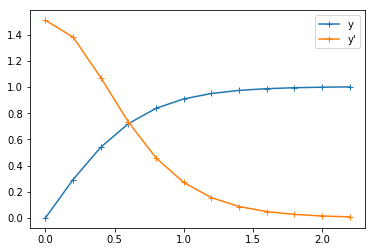

In [13]:
### Example 8.1
a = 0 
alpha = 0
b = 2
beta = 1
X, Y = shooting_o2(F, a, alpha, b, beta, 1/2, 2)
from matplotlib import pyplot as plt
plt.plot(X, Y[:,0], '+-', X, Y[:,1], '+-')
plt.legend(["y", "y'"])
plt.show()

#### Example 8.2

## Finite Difference Method

We split the range of integration (a, b) into $m$ sub-intervals of length $h$ each:

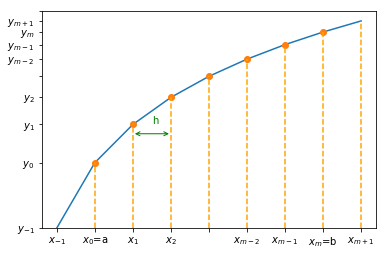

In [14]:
import utils
utils.bp_fd_plot()

The solutions will be computed at the mesh points: $y_0, \ldots, y_m$.

Main principle:
1. The derivatives of $y$ are replaced by their finite difference expressions as in Chapter 5 (here, first central):
$$
y_i' = \frac{y_{i+1}-y_{i-1}}{2h} \quad ; \quad y_i'' = \frac{y_{i-1}-2y_i+y_{i+1}}{h^2}
$$
2. The differential equation will be enforced only at the mesh points.

As a result, the non-linear equations will be replaced by a system of $m+1$ algebraic equations where the unknowns are $y_i$:
* If the differential equation is linear, these equations can be solved by any method in Chapter 2.
* If the differential equation is non-linear, it must be solved using Newton-Raphson (Chapter 4).

### Second-Order Differential Equation

Consider the following problem:
$$
y'' = f(x, y, y')
$$
with the boundary conditions:
$$
y(a) = \alpha \quad \mathrm{or} \quad y'(a) = \alpha \\
y(b) = \beta \quad \mathrm{or} \quad y'(b) = \beta
$$

Using the finite difference approxiximations of y' and y'', we obtain:

$$
\begin{cases}
y_0 - \alpha = 0 & \mathrm{if} \quad  y(a)=\alpha  \\
-2y_0 +2y_1 -h^2f(x_0, y_0, \alpha)-2h\alpha = 0 & \mathrm{if} \quad y'(a) = \alpha
\end{cases}\\
y_{i-1}-2y_i+y_{i+1}-h^2f\left(x_i,y_i,\frac{y_{i+1}-y_{i-1}}{2h}\right)=0 \quad i=1,2\ldots,m-1\\
\begin{cases}
y_m-\beta = 0 & \mathrm{if} \quad y(b)=\beta \\
2y_{m-1}-2y_m-h^2f(x_m,y_m,\beta)+2h\beta = 0 & \mathrm{if} \quad y'(b)=\beta
\end{cases}
$$


#### Example 8.6

Solve the following equations with a computer program, with m=10:
$$
y'' = -4y + 4x \quad ; \quad y(0) = 0 \quad ; \quad y'(\pi/2)=0
$$

In [15]:
# Tridiagonal solver, from CHAPTER 2
def tridiag_decomp(c, d, e):
    assert(len(c) == len(d) == len(e))
    n = len(c)
    for k in range(1, n):
        lambd = c[k-1]/d[k-1]
        d[k] -= lambd*e[k-1]
        c[k-1] = lambd

from numpy import zeros
def tridiag_solve(c, d, e, b): # watch out, input has to be in LU form!
    assert(len(c) == len(d) == len(e) == len(b))
    n = len(c)
    # forward substitution
    for i in range(1, n):
        b[i] = b[i]-c[i-1]*b[i-1] # Here we use b to store y
    # back substitution
    b[n-1] = b[n-1]/d[n-1] # Here we use b to store x
    for i in range (n-2, -1, -1):
        b[i] = (b[i]-e[i]*b[i+1])/d[i]

def tridiag_solver(c, d, e, b): # complete solver for tridiagonal systems
    tridiag_decomp(c, d, e)
    tridiag_solve(c, d, e, b)

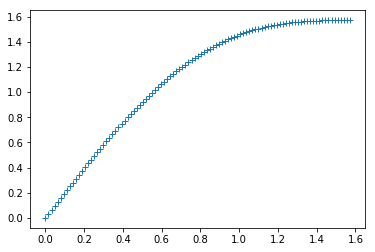

In [16]:
from numpy import array, ones, zeros, arange
from math import pi

m = 100
h = pi/2/m

c = ones(m+1) # lower diagonal elements
d = ones(m+1) # diagonal elements
e = ones(m+1) # upper diagonal elements
b = zeros(m+1) # right-hand terms
x = h*arange(m+1)

e[0] = 0
for i in range(1, m+1):
    d[i] = 4*h**2-2
c[m-1] = 2

b[0] = 0
for i in range(1, m+1):
    b[i] = 4*h**2*x[i]

tridiag_solver(c, d, e, b)
from matplotlib import pyplot as plt
plt.plot(x, b, '+')
plt.show()
#print(x, b)

#### Example 8.7

Solve the boundary value problem:
$$
y'' = -3yy' \quad ; \quad y(0)=0 \quad ; \quad y(2)=1
$$
With the finite difference method. Use m=10 and compare the output with the results of the shooting method in Example 8.1.

In [17]:
### From Chapter 4

from numpy import zeros

def jacobian(f, x):
    '''
    Returns the Jacobian matrix of f taken in x J(x)
    '''
    n = len(x)
    jac = zeros((n, n))
    h = 10E-4
    fx = f(x)
    # go through the columns of J
    for j in range(n):
        # compute x + h ej
        old_xj = x[j]
        x[j] += h
        # update the Jacobian matrix (eq 3)
        # Now x is x + h*ej
        jac[:, j] = (f(x)-fx) / h 
        # restore x[j]
        x[j] = old_xj
    return jac

from numpy.linalg import solve
from numpy import sqrt

def newton_raphson_system(f, init_x, epsilon=10E-4, max_iterations=100):
    '''
    Return a solution of f(x)=0 by Newton-Raphson method.
    init_x is the initial guess of the solution
    '''
    x = init_x
    for i in range(max_iterations):
        J = jacobian(f, x)
        delta_x = solve(J, -f(x)) # we could also use our functions from Chapter 2!
        x = x + delta_x
        if sqrt(sum(delta_x**2)) <= epsilon:
            print("Converged in {} iterations".format(i))
            return x
    raise Exception("Could not find root!")

Converged in 3 iterations


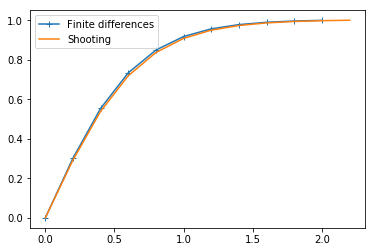

In [18]:
from numpy import array
m = 10
h = 2/m
def f(y): # function for which a zero must be found
    fy = zeros(m+1)
    fy[m] = y[m] - 1
    fy[0] = y[0]
    for i in range(1, m):
        fy[i] = y[i+1] + y[i-1] - 2*y[i] + 3*h**2*y[i]*((y[i+1]-y[i-1])/(2*h))
    return fy
y = newton_raphson_system(f, ones(m+1))
x = h*arange(m+1)
from matplotlib import pyplot as plt
plt.plot(x, y, '+-')
plt.plot(X, Y[:,0], '-') # Shooting method
plt.legend(["Finite differences", "Shooting"])
plt.show()